In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# Import packages
import scipy.io as sio
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

## Importing Data
First we will define the path to where our data is located. We will then use the scipy.io package to load 
the data and convert the format into a pandas DataFrame. DataFrames are a bit like arrays with discriptive names for columns. Values withing them can be indexed both by location and by name.

In [4]:
data_loc = 'pandas_tutorial_events.mat' #- this data is coming from a matlab format array of structures

In [5]:
raw_dat = sio.loadmat(data_loc)
ev_og = raw_dat['events'][0]
ev = ev_og.copy()
evF_og = pd.DataFrame(ev) 
evF_og.head()

,subject,prob,orients,cueLeft,lie,isPractice,correctAngle,correctAngleRad,pLie,mstime,startedAngle,reportedAngle,rt
0,[_5b294d31f32f4],[0.8],"[[43, 72]]",[[0]],[[0]],[[1]],[[72]],[[1.25663706144]],[[0.8]],[[101002]],[[260]],[[260]],[[2140]]
1,[_5b294d31f32f4],[0.8],"[[67, 6]]",[[0]],[[1]],[[1]],[[6]],[[0.10471975512]],[[0.8]],[[109590]],[[260]],[[218]],[[1793]]
2,[_5b294d31f32f4],[0.8],"[[30, 1]]",[[0]],[[0]],[[1]],[[1]],[[0.0174532925199]],[[0.8]],[[120413]],[[218]],[[180]],[[3235]]
3,[_5b294d31f32f4],[0.8],"[[52, 13]]",[[1]],[[0]],[[1]],[[52]],[[0.907571211037]],[[0.8]],[[129494]],[[183]],[[239]],[[2676]]
4,[_5b294d31f32f4],[0.8],"[[65, 180]]",[[0]],[[1]],[[1]],[[180]],[[3.14159265359]],[[0.8]],[[137727]],[[257]],[[182]],[[1684]]


## Cleaning Data
We can quickly view the first few rows of data by using the "head" command (there is also a "tail" command to view the last few rows). The data we want is there... but it is formatted a bit funny. Instead of the DataFrame being populated with values (like floats or integers), it is filled with lists of lists (because of how it imports the file). Instead of always having to deal with this funny formatting, we can right a quick function to make a DataFrame with just the values

In [9]:
def get_var(EV,VAR):
    if VAR == 'prob':
        foo = EV[VAR]
        out = np.array([float(foo[i][0]) for i in range(len(foo))])
    else:
        out = np.concatenate(EV[VAR])
    if len(EV[VAR][0][0])==2: #orients
        return out 
    if np.shape(out[0]):
        out = np.concatenate(out)
    if np.shape(out[0]): #- strings need to be concatenated an extra time
        out = np.concatenate(out)
    return out

def cleanDataFrame(ev,fieldsWant = ['subject','sess_num','lie']):
    print('Adding Fields:\n')
    df = pd.DataFrame() # columns=fieldsWant
    for fld in fieldsWant:
        if fld == 'orients':
            ori = get_var(ev,fld)
            L = [ori[i,0] for i in range(len(ori))]
            R = [ori[i,1] for i in range(len(ori))]
            df['TargL'] = L
            df['TargR'] = R
            print('TargL')
            print('TargR')
        else:
            df[fld] = get_var(ev,fld)
            print(fld) #- nice to reference
    return df

In [10]:
good_fields = ['subject','prob','cueLeft','lie','correctAngle',
             'reportedAngle','rt','orients']
evF = cleanDataFrame(ev,good_fields)
evF.head() 

Adding Fields:

subject
prob
cueLeft
lie
correctAngle
reportedAngle
rt
TargL
TargR


,subject,prob,cueLeft,lie,correctAngle,reportedAngle,rt,TargL,TargR
0,_5b294d31f32f4,0.8,0,0,72,260,2140,43,72
1,_5b294d31f32f4,0.8,0,1,6,218,1793,67,6
2,_5b294d31f32f4,0.8,0,0,1,180,3235,30,1
3,_5b294d31f32f4,0.8,1,0,52,239,2676,52,13
4,_5b294d31f32f4,0.8,0,1,180,182,1684,65,180


## Acessing Values in a dataFrame
Columns can be accessed by dot '.' or backet '[]' notation. Rows and columns can both be accessed by index/number as well. You will notice that each row has a counter assigned to it. This doesn't matter for now but will matter once we get subselect values from the dataFrame. To get just the values we can use the '.values()' command. Lastly, if we grab a slice of a dataFrame, just like with lists and arrays if we change the slice it will change the original dataFrame. To avoid this, we can use the '.copy()' command.

In [26]:
# evF[5:15,'correctAngle']
print(evF[5:15].correctAngle.values)
print(evF['correctAngle'][5:15])


[ 99  15 104  98  50  54 151 113  13  57]
5      99
6      15
7     104
8      98
9      50
10     54
11    151
12    113
13     13
14     57
Name: correctAngle, dtype: uint8


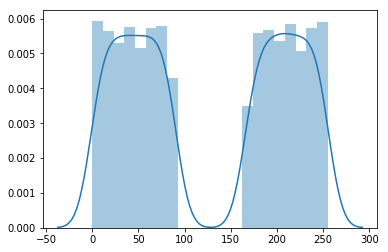

Data type: <class 'numpy.uint8'>


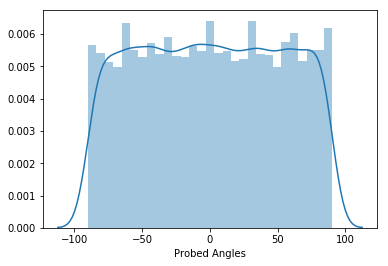

In [29]:
probed_angles = evF.correctAngle.values.copy()
probed_angles_centered = probed_angles-90
sns.distplot(probed_angles_centered)
plt.show()
print('Data type: %s' %type(probed_angles[0])) # be carefull of datatypes! unsigned integers can't be negative.

probed_angles = evF.correctAngle.values.copy().astype(int)
probed_angles_centered = probed_angles-90
sns.distplot(probed_angles_centered)
plt.xlabel('Probed Angles')
plt.show()

## Adding fields to a dataFrame
Now we have a much cleaner data set to work with. We want to add a few additional fields to indicate the angle that wasn't probed. We also want to make sure all reponse angles are in the range [0, 180]. We will also keep the add a field for response error (E) and add a modified RT field that keeps values <8000 ms.

In [30]:
wrongAngle = evF.correctAngle.values.copy() # determine non-target angle
wrongAngle[evF.cueLeft.values==1] = evF.TargR[evF.cueLeft.values==1]
wrongAngle[evF.cueLeft.values==0] = evF.TargL[evF.cueLeft.values==0]
evF['wrongAngle'] = wrongAngle

evF.reportedAngle[evF.reportedAngle.values>180] = evF.reportedAngle[evF.reportedAngle.values>180]-180

E = evF.correctAngle.values.astype(int).copy() - evF.reportedAngle.values.copy() 
E[np.abs(E)>90] = E[np.abs(E)>90] - np.sign(E[np.abs(E)>90])*180
evF['E'] = E

# reduce unreasonable response times to managable values for visualization
rt = evF.rt.values.copy()
m_rt = 8000
rt[rt>m_rt] = m_rt
evF['RTc'] = rt

/Users/tim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
# helper functions
from scipy.stats import circstd
def circ_std(x): return circstd(x,90,-90)
def ismember(a,b):
    status = []
    for aa in a:
        for bb in b:
            if aa==bb:
                status.append(True)
                break  
        else: status.append(False)
    return status

## Quickly visualize the error and response time distribution using the distplot function from the seaborn package:

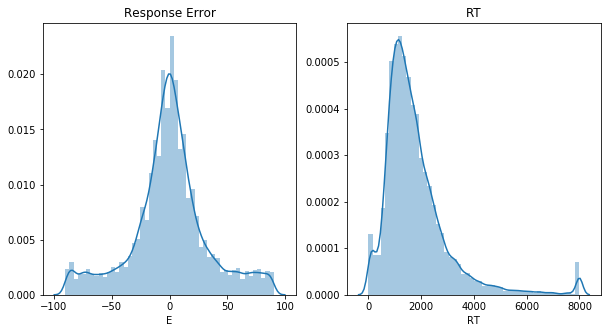

In [32]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(evF.E)
plt.title('Response Error')

plt.subplot(1,2,2)
sns.distplot(rt)
plt.xlabel('RT')
plt.title('RT')
plt.show()

## Remove participants with near chance performance before completing further analysis
This data was collected from Amazon's Mechanical Turk in which willing participants complete tasks from their personal computers for a predetermined payment. Because this is not a controlled environment, data quality can be an issue. As a quick and dirty way to clean the data, we will use list comprehension to get the circular standard deviation of errors for each participant and eliminate those with near chance performance.

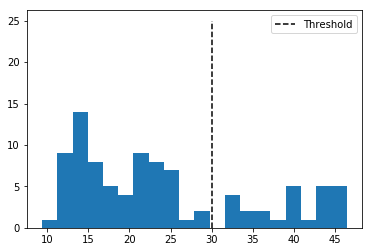

In [33]:
max_err = 30
subjs = np.unique(evF.subject)
sub_err = np.array([np.mean(np.abs(evF[evF.subject==s].E)) for s in subjs])
# sub_err = np.array([circ_std(evF[evF.subject==s].E) for s in subjs]) # List Comprehension
bad_sub = subjs[sub_err>max_err]
bad_ind = np.array(ismember(evF.subject,bad_sub))
evF_use = evF[~bad_ind]

plt.hist(sub_err,20)
plt.plot([max_err,max_err],[0,25],'k--')
plt.legend(('Threshold',))
plt.show()

## Data Visualization
Now that we have "cleaned" the data, we can see look at some of the effects we are interested in. Principally how cue validity effects response variability. We will create a DataFrame to store the outputs of this analysis. For now we will compute the circular standard deviation of errors and response times given the cue validity and its probability of being valid. We will then visualize the output using the seaborn package.

First we will initialize a dataFrame S which we will append to. Pandas "Series" objects are a lot like dictionaries and can easily be added to dataFrames.

In [34]:
# summary by subject
S = pd.DataFrame()
for sub in np.unique(evF_use.subject):
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.subject==sub]
        else:
            dat_use = evF_use[(evF_use.subject==sub)&(evF_use.lie==l)]
        S_ = pd.Series({'subject':sub,'lie':l,'sd':circ_std(dat_use.E),'rt':np.median(dat_use.rt),
                       'prob':dat_use.prob.values[0]}) # Series objects behave like dictionaries and can easily be appended to DataFrames 
        S = S.append(S_,ignore_index=True)            

Once we have our dataFrame from our analysis we can quickly visualize it in a number of ways using the seaborn package. Lets see if response time is effected by our task condition. We can easily overlay different types of plots, in this case a box plot and a swarmplot. Other basic types of plots for 2 variables include **{violin, point, boxen, line, and reg}**

Text(0,0.5,'Response Time')

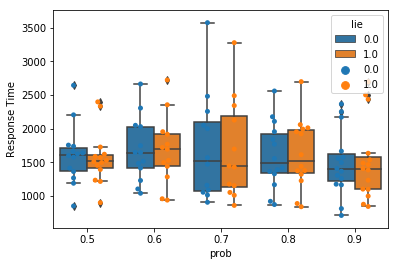

In [35]:
sns.boxplot(x='prob',y='rt',hue='lie',data=S[S.lie!=2])
sns.swarmplot(x='prob',y='rt',hue='lie',data=S[S.lie!=2],dodge=True)
plt.ylabel('Response Time')

Response Times seem to be relatively unaffected by our task conditions. What we are really interested in is the error distributions. For a clean visualization we will use pointplot which automatically computes 95% confidence intervals for each condition. Pretty useful if you want to get a sense of it two groups are meaningfully different.

Text(0.5,1,'Error Variance vs. Cue Validity (retro cue) [raw]')

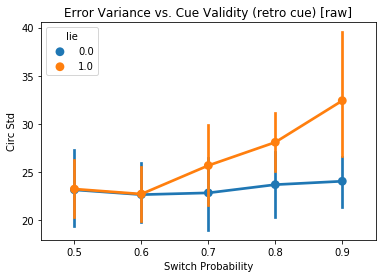

In [36]:
sns.pointplot(x='prob',y='sd',hue='lie',data=S[S.lie!=2])
plt.xlabel('Switch Probability')
plt.ylabel('Circ Std')
# plt.title('Error Variance vs. Cue Validity')
plt.title('Error Variance vs. Cue Validity (retro cue) [raw]')

## Bootstrap Analysis
Clearly the error distribution increases on switch trials with cue validity. It's not clear if this is being mediated by low trial counts in this condition though (the groups with the greatest standard deviation also have the smallest number of trials). To account for this, we can keep the trial counts the same across conditions using bootstrapping.

In [37]:
def quick_boot(x,fun,n_samp_per_boot,n_iterations=30):
    y = []
    for i in range(n_iterations):
        ii = np.floor(np.random.sample(n_samp_per_boot)*len(x)).astype(int)
        xi = x[ii]
        y.append(fun(xi))
    return y

In [38]:
# summary by subject
n_samp_per_boot = 30 #- nTrials per bootstrap

Sb = pd.DataFrame()
for sub in np.unique(evF_use.subject):
    if (sum((evF_use.subject==sub)&(evF_use.lie==1))<n_samp_per_boot):
        print('Skipping %s, not enough switch trials' %(sub,))
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.subject==sub]
        else:
            dat_use = evF_use[(evF_use.subject==sub)&(evF_use.lie==l)]
        S_ = pd.Series({'subject':sub,'lie':l,'rt':np.median(dat_use.rt),
                       'prob':dat_use.prob.values[0]}) # Series objects behave like dictionaries and can easily be appended to DataFrames 
        sd = quick_boot(dat_use.E.values,circ_std,n_samp_per_boot)
        S_['sd'] = np.mean(sd)
        Sb = Sb.append(S_,ignore_index=True)            

Skipping _5b2aac5092167, not enough switch trials
Skipping _5b2aad4671830, not enough switch trials
Skipping _5b2aaddf171c2, not enough switch trials
Skipping _5b2aae3ef25c4, not enough switch trials
Skipping _5b2aae48a8c78, not enough switch trials
Skipping _5b2aaf0d2bfd8, not enough switch trials
Skipping _5b2aaf84de1fb, not enough switch trials
Skipping _5b2aafd6e86a5, not enough switch trials
Skipping _5b2ab0fa35798, not enough switch trials
Skipping _5b2ab81796bed, not enough switch trials
Skipping _5b2abddebbc69, not enough switch trials
Skipping _5b2abdefee286, not enough switch trials
Skipping _5b2ac9a99106a, not enough switch trials


Text(0.5,1,'Error Variance vs. Cue Validity (retro cue) [boot 30|30]')

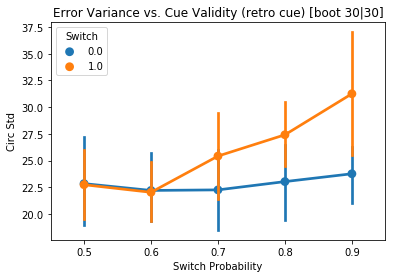

In [39]:
g = sns.pointplot(x='prob',y='sd',hue='lie',data=Sb[Sb.lie!=2], legend_out = True)
g.legend_.set_title('Switch')
plt.xlabel('Switch Probability')
plt.ylabel('Circ Std')
plt.title('Error Variance vs. Cue Validity (retro cue) [boot 30|30]')

It looks like the effects of cue validity are indeed due to behavioral differences and not an artifact of trial counts. What if we looked at differences within subjects

In [40]:
Sd = pd.DataFrame()
for sub in np.unique(Sb.subject):
    S_ = pd.Series({'d_sd':Sb[(Sb.subject==sub)&(Sb.lie==0)].sd.values[0]-Sb[(Sb.subject==sub)&(Sb.lie==1)].sd.values[0],
                    'prob':Sb[(Sb.subject==sub)&(Sb.lie==2)].prob.values[0]})
    Sd = Sd.append(S_,ignore_index=True)

Text(0.5,0,'Cue Validity')

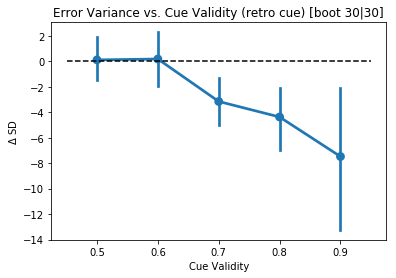

In [41]:
sns.pointplot(x='prob',y='d_sd',data=Sd)
# sns.swarmplot(x='prob',y='d_sd',data=Sd,dodge=1)
plt.plot([-.5, 4.5],[0,0],'k--') # add a line to represent our null hypothesis (no difference between stay and switch conditions)
plt.title('Error Variance vs. Cue Validity (retro cue) [boot 30|30]')
plt.xlabel('Switch Probability')
plt.ylabel('$\Delta$ SD')
plt.xlabel('Cue Validity')

## Pooled Analysis
Above analysis grouped by validity
1. raw (no bars)
1. boot (bars = bootstraps, find good size)
1. bootD (bars = bootstraps, find good size)

In [42]:
# summary by validity
Sp = pd.DataFrame()
for val in np.unique(evF_use.prob):
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.prob==val]
        else:
            dat_use = evF_use[(evF_use.prob==val)&(evF_use.lie==l)]
            
        S_ = pd.Series({'lie':l,'sd':circ_std(dat_use.E),'rt':np.median(dat_use.rt),
                       'prob':val}) # Series objects behave like dictionaries and can easily be appended to DataFrames 
        Sp = Sp.append(S_,ignore_index=True)      

Text(0.5,1,'Error Variance vs. Cue Validity (retro cue) [pooled]')

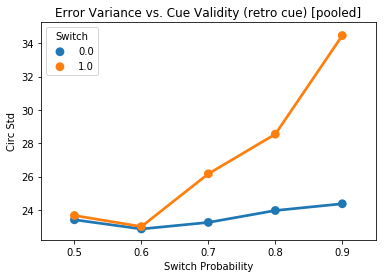

In [43]:
g=sns.pointplot(x='prob',y='sd',hue='lie',data=Sp[Sp.lie!=2],legend_out=True)
g.legend_.set_title('Switch')
plt.xlabel('Switch Probability')
plt.ylabel('Circ Std')
plt.title('Error Variance vs. Cue Validity (retro cue) [pooled]')

Text(0.5,0,'Switch Probability')

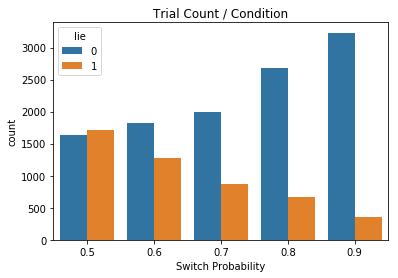

In [44]:
sns.countplot(x='prob',hue='lie',data=evF_use)
plt.title('Trial Count / Condition')
plt.xlabel('Switch Probability')

In [45]:
Sp_boot = pd.DataFrame()
n_samp_per_boot = 300 # 354 in smallest group
for val in np.unique(evF_use.prob):
    for l in (0,1,2):
        if (l==2):
            dat_use = evF_use[evF_use.prob==val]
        else:
            dat_use = evF_use[(evF_use.prob==val)&(evF_use.lie==l)]
            
        S_ = pd.Series({'lie':l,'rt':np.median(dat_use.rt),
                       'prob':val}) # ,'sd':circ_std(dat_use.E)
        
        sd = quick_boot(dat_use.E.values,circ_std,n_samp_per_boot)
        for ss in sd:
            S_['sd'] = ss
            Sp_boot = Sp_boot.append(S_,ignore_index=True)

Text(0.5,1,'Error Variance vs. Cue Validity (retro cue) [boot 300|30]')

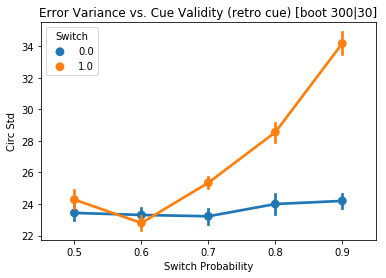

In [46]:
g=sns.pointplot(x='prob',y='sd',hue='lie',data=Sp_boot[Sp_boot.lie!=2],legend_out=True)
g.legend_.set_title('Switch')
plt.xlabel('Switch Probability')
plt.ylabel('Circ Std')
plt.title('Error Variance vs. Cue Validity (retro cue) [boot 300|30]')

In [47]:
Sp_boot_D = pd.DataFrame()
for val in np.unique(Sp_boot.prob):
    this_0 = Sp_boot[(Sp_boot.prob==val)&(Sp_boot.lie==0)].sd.values
    this_1 = Sp_boot[(Sp_boot.prob==val)&(Sp_boot.lie==1)].sd.values
    this_d = this_0-this_1
    S_ = pd.Series({'prob':val})
    for dd in this_d:
        S_['sd'] = dd
        Sp_boot_D = Sp_boot_D.append(S_,ignore_index=True)

Text(0.5,1,'Error Variance vs. Cue Validity (retro cue) [boot 300|30]')

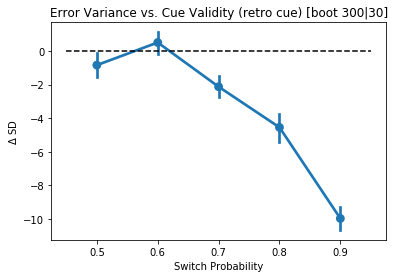

In [48]:
g=sns.pointplot(x='prob',y='sd',data=Sp_boot_D,legend_out=True)
plt.ylabel('$\Delta$ SD')
plt.xlabel('Switch Probability')
plt.plot([-.5, 4.5],[0,0],'k--') 
plt.title('Error Variance vs. Cue Validity (retro cue) [boot 300|30]')

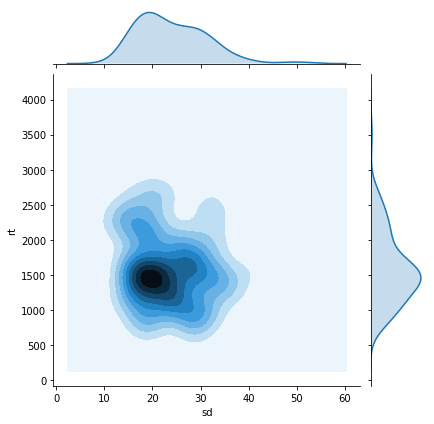

In [52]:
sns.jointplot(x='sd',y='rt',data=Sb,kind='kde')

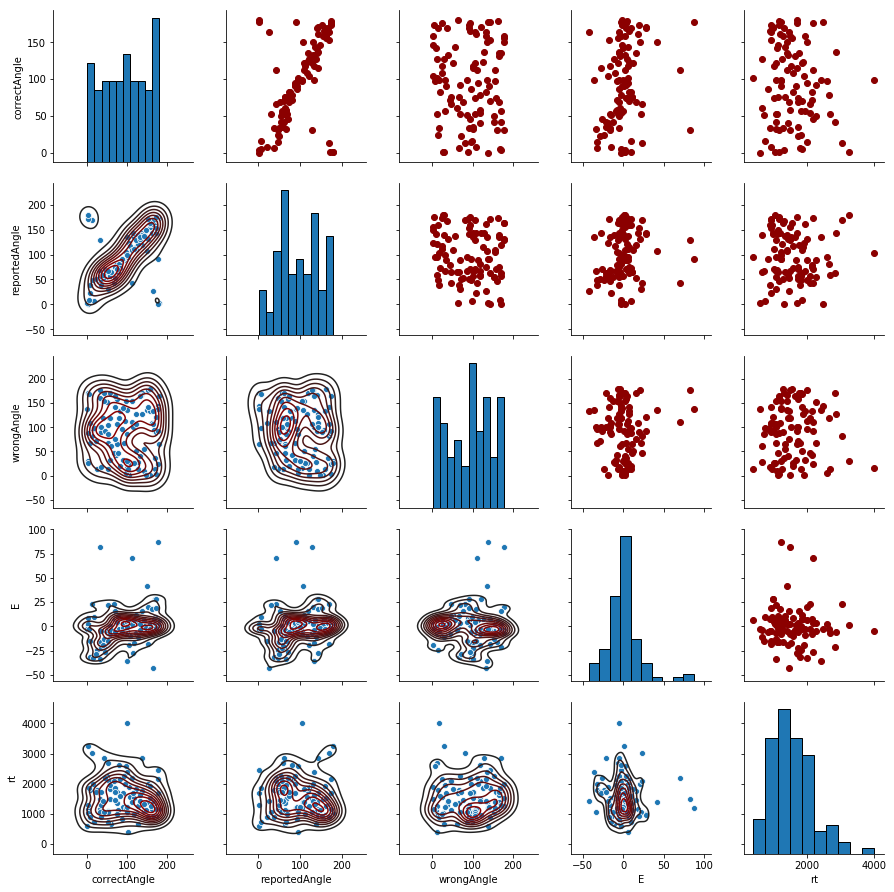

In [61]:
ax = sns.pairplot(evF_use[:100],
                  vars =['correctAngle','reportedAngle','wrongAngle','E','rt'])
ax = ax.map_upper(plt.scatter, color = 'darkred')
ax = ax.map_lower(sns.kdeplot, color = 'darkred')
ax = ax.map_diag(plt.hist, bins = 10, edgecolor =  'k');